Datset on New York in 2013 found at: https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls

In [1]:
import math

from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import scipy
import statsmodels.formula.api as smf
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action='ignore', module='scipy', message='^internal gelsd')

In [2]:
# Read data using pandas
df = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls')

In [3]:
# Data Cleaning

# Delete first three rows
df = df.drop([0,1,2], axis=0)

# Make first row the column headers
df = df.reset_index(drop=True)
df.columns = df.iloc[0]
df = df.drop([0], axis=0)
df = df.reset_index(drop=True)

# Rename all column headers
df.columns = ['City', 'Population', 'Violent Crime', 'Murder and Nonnegligent Manslaughter', 'Rape (revised definition)', 'Rape (legacy definition)', 'Robbery', 'Aggravated Assault', 'Property Crime', 'Burglary', 'Larceny-Theft', 'Motor Vehicle Theft', 'Arson']


# Remove entire Unnamed: 4 or 'Rape revised defintion'
df = df.drop('Rape (revised definition)', axis=1)

# Remove null objects
df = df.drop([348, 349, 350], axis=0)
df = df.drop('Arson', axis=1)
df = df.dropna(how='all')

#Convert Columns from object to integer
df[['Population', 'Violent Crime',
       'Murder and Nonnegligent Manslaughter', 'Rape (legacy definition)',
       'Robbery', 'Aggravated Assault', 'Property Crime', 'Burglary',
       'Larceny-Theft', 'Motor Vehicle Theft']] = df[['Population', 'Violent Crime',
       'Murder and Nonnegligent Manslaughter', 'Rape (legacy definition)',
       'Robbery', 'Aggravated Assault', 'Property Crime', 'Burglary',
       'Larceny-Theft', 'Motor Vehicle Theft']].astype(int)

#Rename murder column to 'Murder'
df = df.rename(columns = {'Murder and Nonnegligent Manslaughter':'Murder'})

# Remove New York and buffalo from data because it skews the data. Although the data is correct
df[df['City'] == 'New York']
df = df[(df['City']!='New York')&(df['City']!='Buffalo')]

# Change name of Property Crime and Aggravated Assault so that it's one word
df['Propertycrime'] = df['Property Crime']
df = df.drop(columns=['Property Crime'])

df['Rape'] = df['Rape (legacy definition)']
df = df.drop(columns=['Rape (legacy definition)'])

df['Aggravated_Assault'] = df['Aggravated Assault']
df = df.drop(columns=['Aggravated Assault'])

df['MotorVehicleTheft'] = df['Motor Vehicle Theft']
df = df.drop(columns=['Motor Vehicle Theft'])

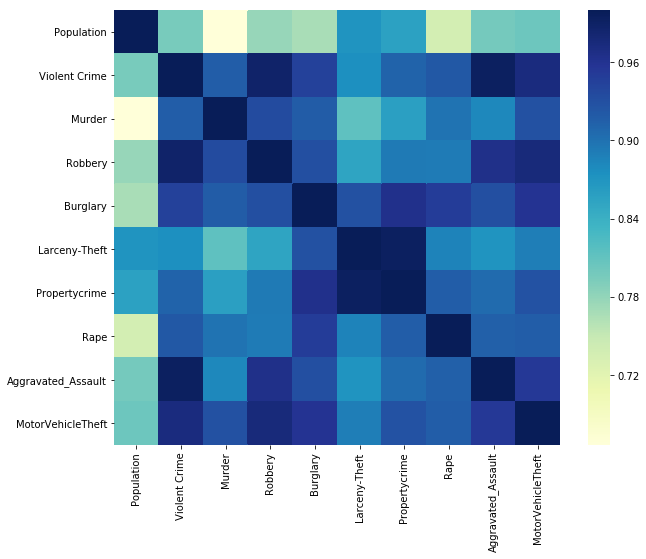

In [4]:
plt.figure(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr, cmap='YlGnBu')

In [6]:
df1 = np.log(df.drop('City', axis=1)+1)

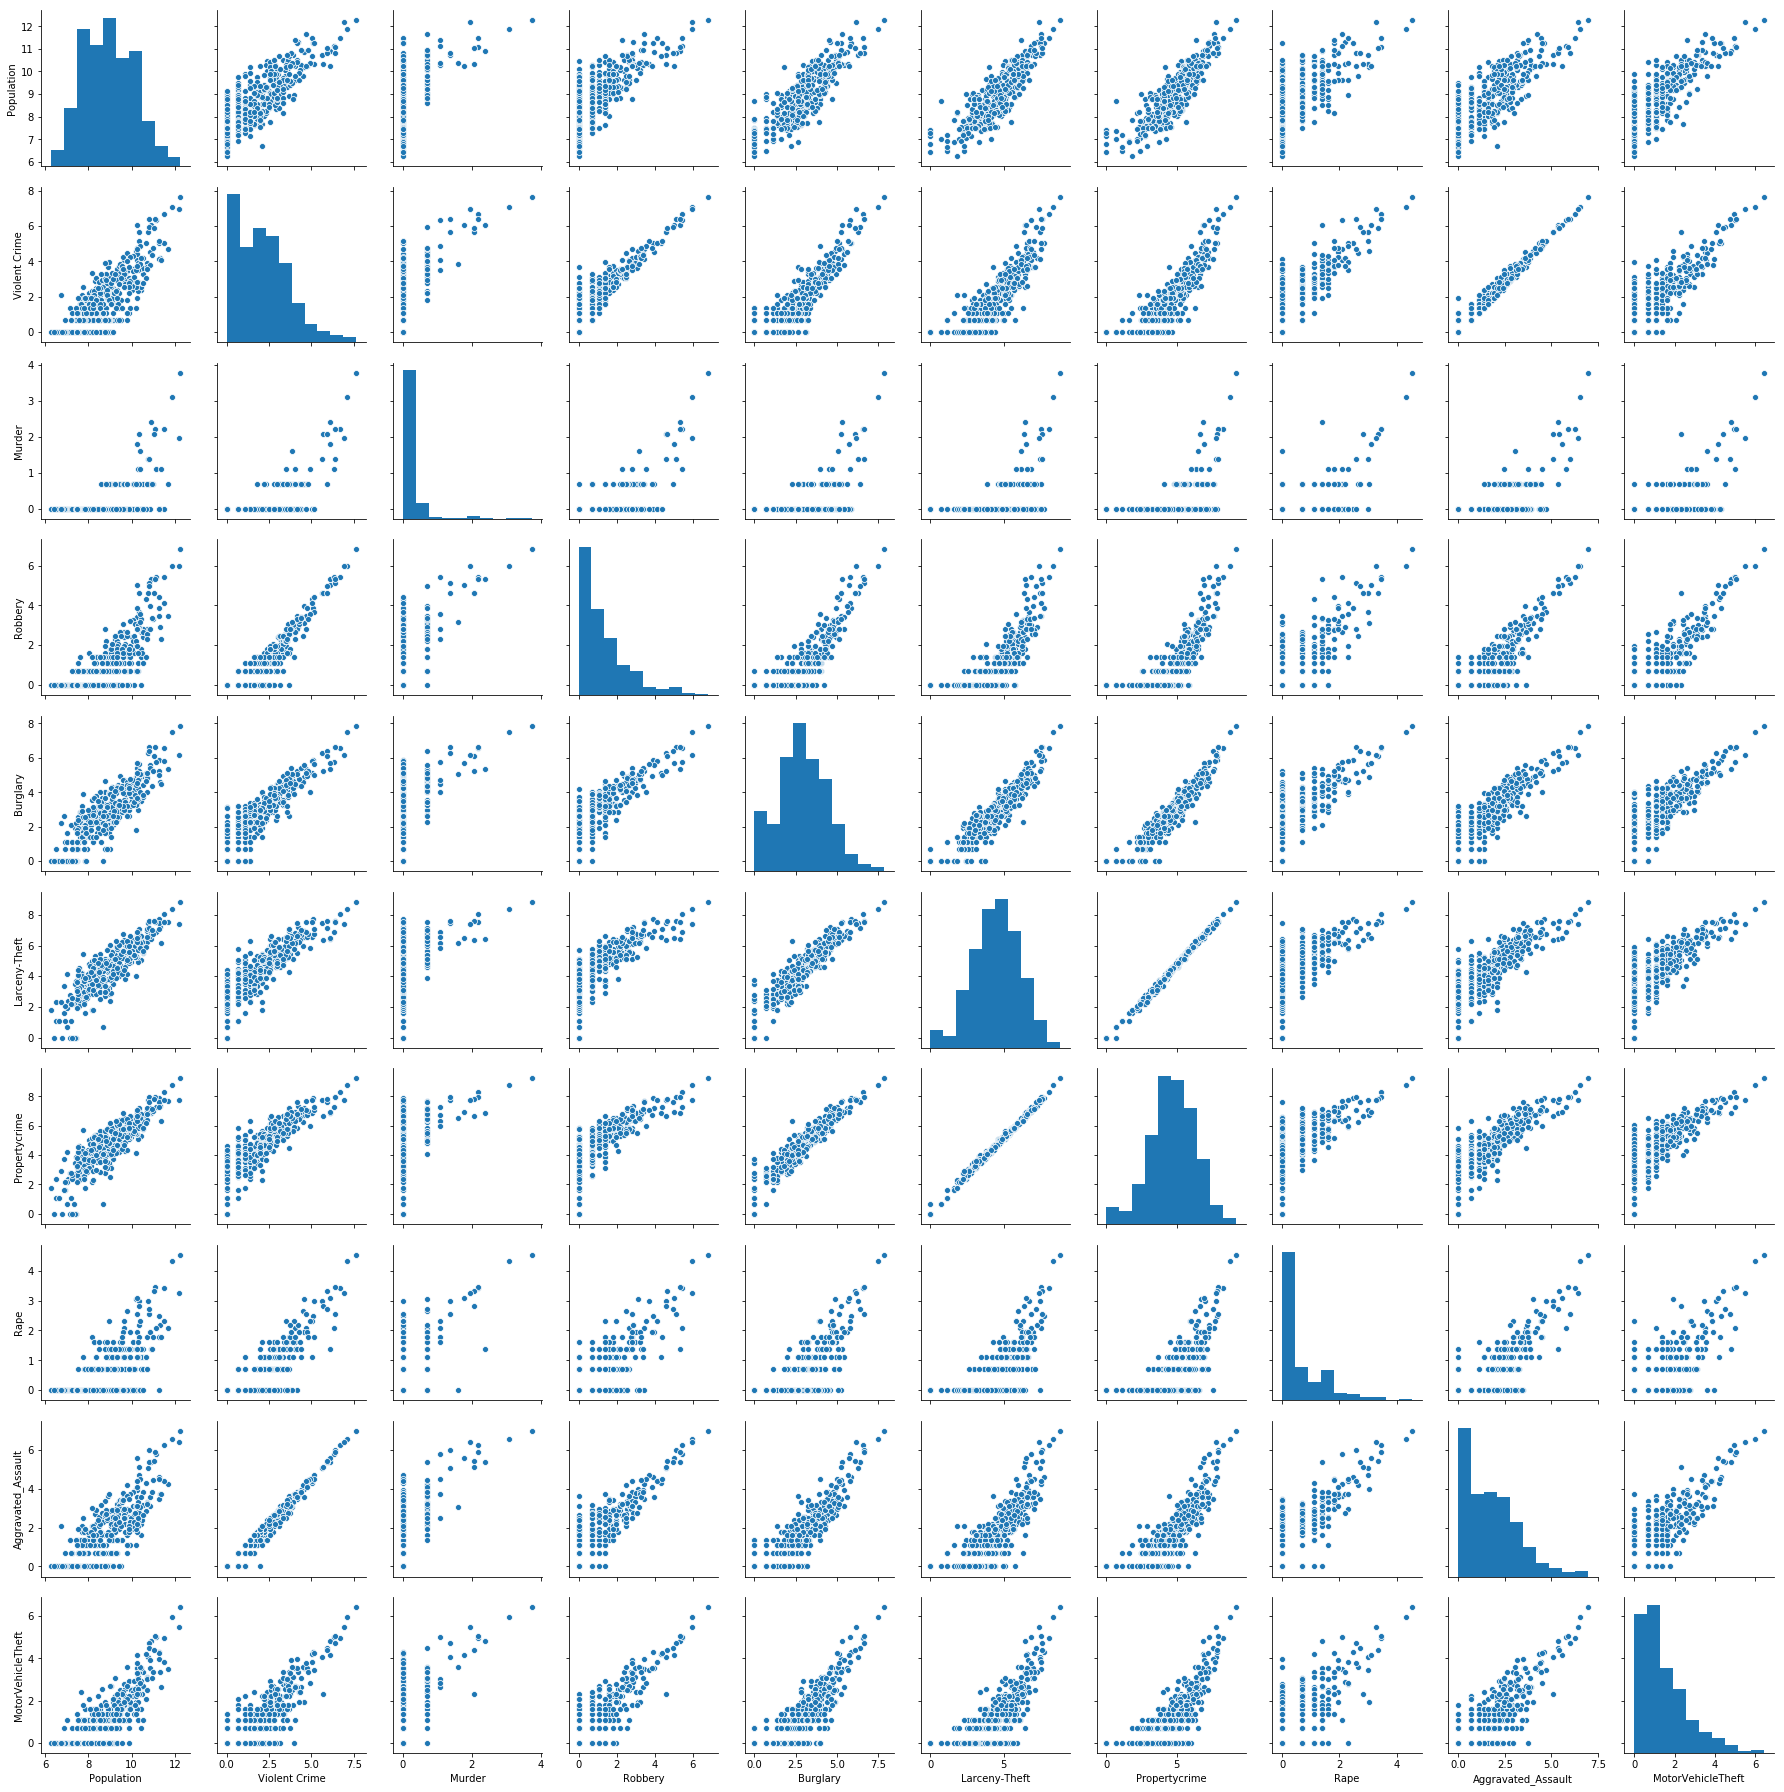

In [7]:
sns.pairplot(df1)

In [8]:
#df['Theft'] = df['MotorVehicleTheft']*df['Robbery']*df['Larceny-Theft']

Binarize the non-normal variables

In [9]:
#plt.figure(figsize=(10,8))
#sns.distplot(df['Theft'])

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


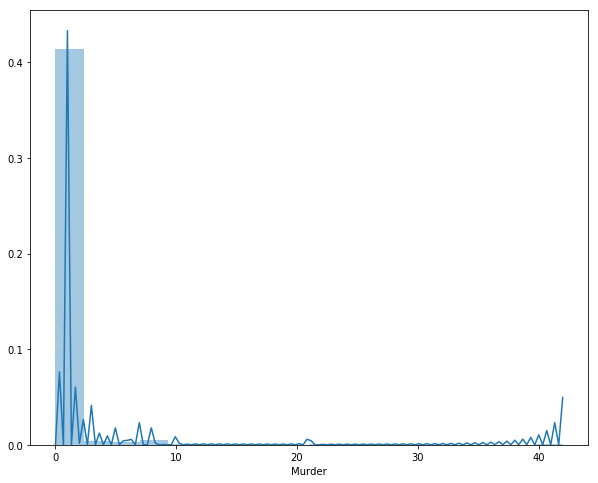

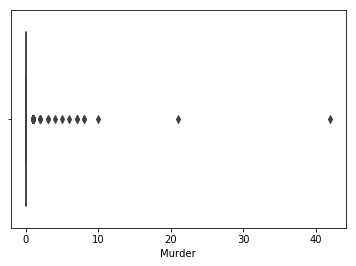

In [10]:
plt.figure(figsize=(10,8))
sns.distplot(df['Murder'])
plt.show()

sns.boxplot(x = df['Murder'])
plt.show()

In [11]:
df.Murder.quantile(.95)

1.0

In [12]:
df[df.Murder<=1].describe()

,Population,Violent Crime,Murder,Robbery,Burglary,Larceny-Theft,Propertycrime,Rape,Aggravated_Assault,MotorVehicleTheft
count,330.000,330.000,330.000,330.000,330.000,330.000,330.000,330.000,330.000,330.000
mean,12240.233,16.918,0.094,4.870,36.761,203.609,246.109,1.236,10.718,5.739
std,15459.546,33.556,0.292,12.604,59.511,315.538,376.504,2.580,19.791,11.243
min,526.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2843.000,2.000,0.000,0.000,6.000,29.000,38.000,0.000,1.000,0.000
50%,6688.500,5.000,0.000,1.000,16.000,88.000,105.000,0.000,4.000,2.000
75%,15294.250,17.750,0.000,4.000,43.750,241.750,309.250,1.000,12.000,5.000
max,118296.000,371.000,1.000,145.000,593.000,2271.000,2689.000,20.000,211.000,87.000


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


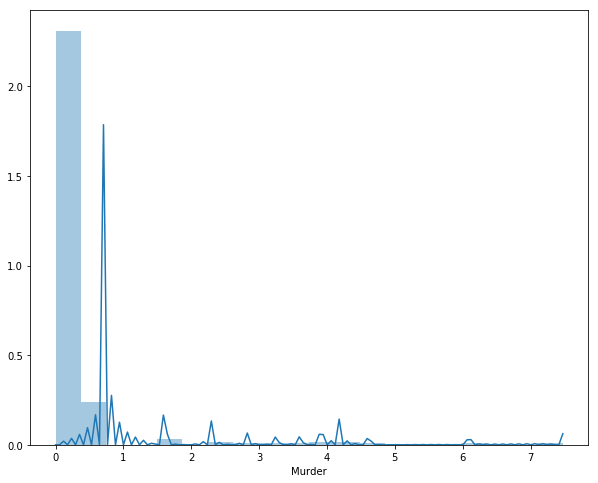

In [13]:
plt.figure(figsize=(10,8))
sns.distplot(np.log((df['Murder']**2)+1), bins=20)

Murder should be Binary

In [14]:
# Create more Features

# Combine variance of Violent Crime, Aggravated_Assault and Larceny-Theft
means = df[['Violent Crime', 'Aggravated_Assault', 'Larceny-Theft']].mean(axis=0)
stds = df[['Violent Crime', 'Aggravated_Assault', 'Larceny-Theft']].std(axis=0)
df['Violent_Assault_Larcency'] = ((df[['Violent Crime', 'Aggravated_Assault', 'Larceny-Theft']] - means)/stds).mean(axis=1)

# Combine variance of Rape and MotorVehicleTheft
means = df[['Rape', 'MotorVehicleTheft']].mean(axis=0)
stds = df[['Rape', 'MotorVehicleTheft']].std(axis=0)
df['Rape_MotorVehicleTheft'] = ((df[['Rape', 'MotorVehicleTheft']] - means)/stds).mean(axis=1)

# Create Features: Population_squared, Murder binary, Robbery, binary
df['Population'] = np.log(df['Population']+1)
#df['ViolentCrime_squared'] = df['Violent Crime']**2
#df['Robbery_squared'] = df['Robbery']**2
#df['Violent-Larceny'] = df['Violent Crime']*df['Larceny-Theft']
df['Murder'] = np.where(df['Murder']>0, 1, 0)#df['Robbery'] = np.where(df['Robbery']>0, '1', '0')


In [15]:
df.head()

,City,Population,Violent Crime,Murder,Robbery,Burglary,Larceny-Theft,Propertycrime,Rape,Aggravated_Assault,MotorVehicleTheft,Violent_Assault_Larcency,Rape_MotorVehicleTheft
0,Adams Village,7.529,0,0,0,2,10,12,0,0,0,-0.332,-0.283
1,Addison Town and Village,7.855,3,0,0,3,20,24,0,3,1,-0.309,-0.271
2,Akron Village,7.954,3,0,0,1,15,16,0,3,0,-0.312,-0.283
3,Albany,11.492,791,1,227,705,3243,4090,30,526,142,5.084,3.290
4,Albion Village,8.762,23,0,4,53,165,223,3,16,5,-0.137,-0.028


In [33]:
# Logist Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score

logreg = LogisticRegression()
logregl2 = LogisticRegression(penalty='l2')
logregl1 = LogisticRegression(penalty='l1')

y = df['Murder'].values.reshape(-1, 1)
x = df.drop(columns=['City', 'Murder'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

logreg.fit(x_train, y_train)

y_pred = logreg.predict(x)

print('Accuracy of Logistic Regression Model for predicting Murder in New York = ' + str(logreg.score(x_train, y_train)))

print(cross_val_score(logreg, x_test, y_test, cv = 5))

pd.crosstab(y_pred, df['Murder'].values)


Accuracy of Logistic Regression Model for predicting Murder in New York = 0.9669421487603306
[0.86363636 0.85714286 0.95238095 0.95       0.95      ]


/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

col_0,0,1
row_0,,
0,299,11
1,0,36


In [17]:
# Pass logistic regression model to the RFE constructor
from sklearn.feature_selection import RFE

selector = RFE(logreg)
selector = selector.fit(df.drop('City', axis=1), df['Murder'])
print(selector.ranking_)

[2 1 1 1 4 6 7 1 1 5 1 3]


In [18]:
rankings = pd.DataFrame({'Features': df.drop('City', axis=1).columns, 'Ranking' : selector.ranking_})
rankings.sort_values('Ranking')


,Features,Ranking
1,Violent Crime,1
2,Murder,1
3,Robbery,1
7,Rape,1
8,Aggravated_Assault,1
10,Violent_Assault_Larcency,1
0,Population,2
11,Rape_MotorVehicleTheft,3
4,Burglary,4
9,MotorVehicleTheft,5


In [19]:
df['Murder'].mean()

0.13583815028901733

In [20]:
df['Murder'].sum()/df.shape[0]

0.13583815028901733

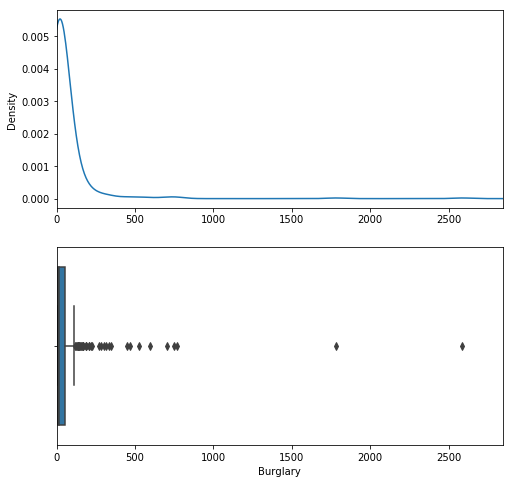

In [21]:
# Log transform Burglary Variable and remove Outliers

i = 'Burglary'

plt.figure(figsize=(8,8))
plt.subplot(211)
plt.xlim(df[i].min(), df[i].max()*1.1)

ax = df[i].plot(kind = 'kde')

plt.subplot(212)
plt.xlim(df[i].min(), df[i].max()*1.1)
sns.boxplot(x = df[i])

Shift data by 1 and try log transformation

In [22]:
# Remove any zeros (otherwise we get (-inf)
#df.loc[df.Burglary == 0, 'Burglary'] = np.nan

# Series + 1 and then take log to avoid (-inf)

# Drop Na
df.dropna(inplace=True)

# Log Transformation
df['log_' + i] = np.log(df[i] + 1)

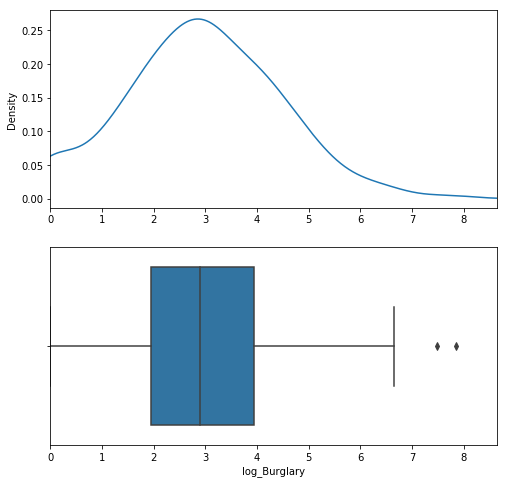

In [23]:
# Visualize Logged distribution
i = 'log_Burglary'

plt.figure(figsize=(8,8))
plt.subplot(211)
plt.xlim(df[i].min(), df[i].max()*1.1)

ax = df[i].plot(kind = 'kde')

plt.subplot(212)
plt.xlim(df[i].min(), df[i].max()*1.1)
sns.boxplot(x = df[i])

In [24]:
q75,q25 = np.percentile(df.log_Burglary.dropna(), [75,25])
iqr = q75 - q25

min = q25 - (iqr*1.5)
max = q75 + (iqr*1.5)

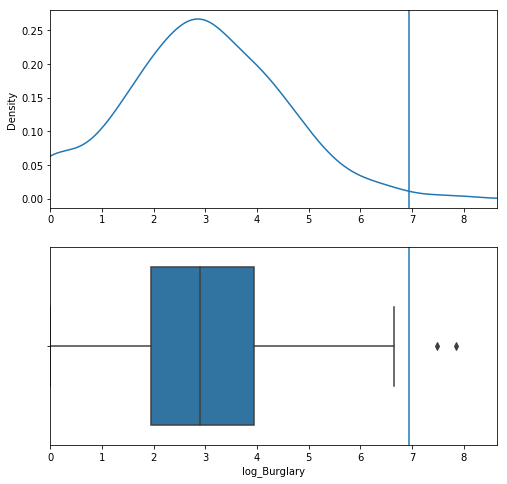

In [25]:
# Visualize Outliers
i = 'log_Burglary'

plt.figure(figsize=(8,8))
plt.subplot(211)
plt.xlim(df[i].min(), df[i].max()*1.1)
plt.axvline(x=min)
plt.axvline(x=max)

ax = df[i].plot(kind = 'kde')

plt.subplot(212)
plt.xlim(df[i].min(), df[i].max()*1.1)
sns.boxplot(x = df[i])
plt.axvline(x=min)
plt.axvline(x=max)

In [26]:
# Remove Outliers
df['Outliers'] = 0

df.loc[df[i] < min, 'Outliers'] = 1
df.loc[df[i] > max, 'Outliers'] = 1

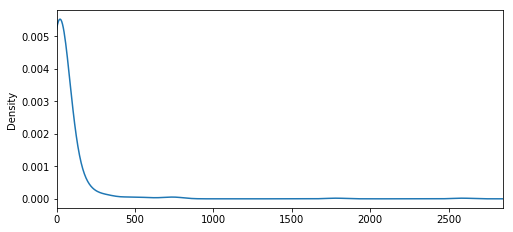

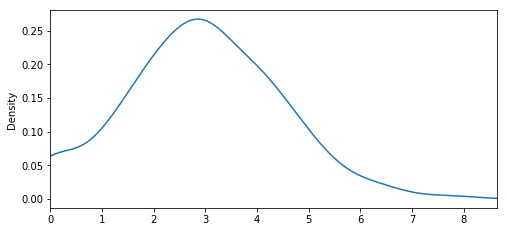

In [27]:
# Compare original Data with cleaned, log transformed data
i = 'Burglary'

plt.figure(figsize=(8,8))
plt.subplot(211)
plt.xlim(df[i].min(), df[i].max()*1.1)
ax = df[i].plot(kind = 'kde')

i = 'log_Burglary'
plt.figure(figsize=(8,8))
plt.subplot(211)
plt.xlim(df[i].min(), df[i].max()*1.1)
ax = df[i].plot(kind = 'kde')

In [28]:
# Compile Features
features = pd.DataFrame()
features = df.drop(columns=['log_Burglary', 'Outliers', 'Violent_Assault_Larcency', 'Rape',])
features.head()

,City,Population,Violent Crime,Murder,Robbery,Burglary,Larceny-Theft,Propertycrime,Aggravated_Assault,MotorVehicleTheft,Rape_MotorVehicleTheft
0,Adams Village,7.529,0,0,0,2,10,12,0,0,-0.283
1,Addison Town and Village,7.855,3,0,0,3,20,24,3,1,-0.271
2,Akron Village,7.954,3,0,0,1,15,16,3,0,-0.283
3,Albany,11.492,791,1,227,705,3243,4090,526,142,3.290
4,Albion Village,8.762,23,0,4,53,165,223,16,5,-0.028


# Logistic Regression

In [29]:
# Logist Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

logreg = LogisticRegression()
logregl2 = LogisticRegression(penalty='l2')
logregl1 = LogisticRegression(penalty='l1')

y = features['Murder_Binary'].values.reshape(-1, 1)
x = features.drop(columns=['City', 'Murder_Binary', 'Murder'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_test)

print('Accuracy of Logistic Regression Model for predicting Murder in New York = ' + str(logreg.score(x_test, y_test)))


KeyError: 'Murder_Binary'

In [ ]:
# Confusion Matrix to view errors
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

In [ ]:
# Compute precision, recall, F-mearue and support
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# L2 (Ridge) Logistic Regression

In [ ]:
logregl2.fit(x_train, y_train)

y_pred = logregl2.predict(x_test)

print('Accuracy of Logistic Regression Model for predicting Murder in New York = ' + str(logregl2.score(x_test, y_test)))

In [ ]:
# Confusion Matrix to view errors
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

In [ ]:
# Compute precision, recall, F-mearue and support
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# L1 (Lasso) Logistic Regression

In [ ]:
logregl1.fit(x_train, y_train)

y_pred = logregl1.predict(x_test)

print('Accuracy of Logistic Regression Model for predicting Murder in New York = ' + str(logregl1.score(x_test, y_test)))

In [ ]:
# Confusion Matrix to view errors
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

In [ ]:
# Compute precision, recall, F-mearue and support
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

### Observations

In the models above we've combined logistic regression with regularization by tuning the parameter to penalties like L1 and L2 repressenting lasso and ridge regularization.

Regular Logistic Regression and Ridge Regression gives the same level of accuracy when classifying Murder at 88%.

Lasso regression improves the model by 4 percent to 92%.

# Ridge Regression

In [ ]:
from sklearn import linear_model

ridge = linear_model.Ridge(alpha=1, fit_intercept=False)

y = features['Murder'].values.reshape(-1, 1)
x = features.drop(columns=['City', 'Murder'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)
print(ridge.score(x_test, y_test))

# Lasso Regression

In [ ]:
from sklearn import linear_model

lasso = linear_model.Lasso(alpha=1.5)

y = features['Murder'].values.reshape(-1, 1)
x = features.drop(columns=['City', 'Murder'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

lasso.fit(x_train, y_train)
y_pred = lasso.predict(x_test)
print(lasso.score(x_test, y_test))

# Ridge and Lasso Observations

Neither the Ridge nor Lasso regressions have show promising models for classifying Murder. The R squared value for the Ridge regression is negative, indicating the value wasn't squared because the model was so poor. Further more, the lasso regression has a model accuracy of 38%. Changing the lambda value doesn't improve either model by much.

# Final Conclusions

Logistic Regression coupled with tuning the parameters to Lasso regression provides the most accurate model at 92% and so is the best by far. Furthermore, the the logistic L1 regression also has consistent precision, recall scores at 92% and F-score rates at 91%. This shows us that the models ability to predict true positive values are quite strong.

However, even logistic regression isn't the best predictor of this model. The variables of this model have multicollinearity and there aren't many columns with large data point that would encourage using ridge or lasso regression. Because of the multicollinearity, adding new variables that are quaratic or cubic might multiply the overfitting that's already occuring. Therefore, a different model, may be more appropriate.

# Optimizing these Models

After speaking with mentor, I've identified multiple techniques and approaches I can use to optimize this model, and possibly others. Because of the positive skews in data, either a 1 + log transformation or a binary converstion are appropriate to use the variables for the models.

In redoing the models, you should do the following:
1. Run models with given features of baseline results.
2. Apply log+1 transformation to population variable and rerun models for baseline results.
3. Apply log+1 transformation to each predictor variable that then returns a normal distribution and then reapply model for baseline results.
4. Create Binary variables with predictors that are very positively skewed even after log transformations and rerun model.
5. Create RFE rankings to rank the importance of each variable in relation to predicting the ouctome, murder.

When running model your goal is to:
1. Return results that have consistent scores in cross validations
2. Cross tab results to visualize type I and II errors